## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [4]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os

# from week0_10_cnn.week10_cnn_seminar import logits

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [13]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [14]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

In [15]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [16]:
len(fmnist_dataset_test)

10000

In [17]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [84]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, num_classes)
        )
        
    def forward(self, inp):       
        return self.model(inp)

In [85]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
       BatchNorm1d-3                  [-1, 512]           1,024
              ReLU-4                  [-1, 512]               0
           Dropout-5                  [-1, 512]               0
            Linear-6                  [-1, 256]         131,328
       BatchNorm1d-7                  [-1, 256]             512
              ReLU-8                  [-1, 256]               0
           Dropout-9                  [-1, 256]               0
           Linear-10                  [-1, 128]          32,896
      BatchNorm1d-11                  [-1, 128]             256
             ReLU-12                  [-1, 128]               0
          Dropout-13                  [-1, 128]               0
           Linear-14                   

Your experiments come here:

In [89]:
def train_one_epoch(model, loader, optimizer, loss_fn, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for x, y in loader:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        logits = model(x)
        loss = loss_fn(logits, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * y.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def evaluate(model, loader, loss_fn, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            logits = model(x)
            loss = loss_fn(logits, y)

            running_loss += loss.item() * y.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def train_model(model, train_loader, test_loader, optimizer, loss_fn, device, num_epochs):
    history = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": [],
    }

    for epoch in range(1, num_epochs + 1):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, loss_fn, device)
        test_loss, test_acc = evaluate(model, test_loader, loss_fn, device)

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["test_loss"].append(test_loss)
        history["test_acc"].append(test_acc)

        print(
            f"Epoch {epoch:02d}: "
            f"train_loss={train_loss:.4f}, train_acc={train_acc:.4f}, "
            f"test_loss={test_loss:.4f}, test_acc={test_acc:.4f}"
        )

    return history

In [96]:
def plot_loss_and_accuracy(history, title_prefix="Model"):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(12, 4))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label="Train loss")
    plt.plot(epochs, history["test_loss"], label="Test loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{title_prefix}: loss")
    plt.legend()
    plt.grid(True)

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_acc"], label="Train accuracy")
    plt.plot(epochs, history["test_acc"], label="Test accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{title_prefix}: accuracy")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [97]:
model = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(
    model.parameters(),
    lr=1e-3,
    weight_decay=1e-4
)
loss_func = nn.CrossEntropyLoss()

In [98]:
num_epochs = 20
history_tiny = train_model(
    model,
    train_loader,
    test_loader,
    opt,
    loss_func,
    device,
    num_epochs
)


Epoch 01: train_loss=0.5065, train_acc=0.8255, test_loss=0.4132, test_acc=0.8483
Epoch 02: train_loss=0.3764, train_acc=0.8628, test_loss=0.3756, test_acc=0.8637
Epoch 03: train_loss=0.3388, train_acc=0.8762, test_loss=0.3727, test_acc=0.8675
Epoch 04: train_loss=0.3204, train_acc=0.8818, test_loss=0.3534, test_acc=0.8696
Epoch 05: train_loss=0.3042, train_acc=0.8880, test_loss=0.3339, test_acc=0.8728
Epoch 06: train_loss=0.2906, train_acc=0.8912, test_loss=0.3382, test_acc=0.8757
Epoch 07: train_loss=0.2818, train_acc=0.8958, test_loss=0.3377, test_acc=0.8733
Epoch 08: train_loss=0.2720, train_acc=0.8994, test_loss=0.3506, test_acc=0.8698
Epoch 09: train_loss=0.2626, train_acc=0.9020, test_loss=0.3249, test_acc=0.8802
Epoch 10: train_loss=0.2584, train_acc=0.9042, test_loss=0.3271, test_acc=0.8797
Epoch 11: train_loss=0.2509, train_acc=0.9074, test_loss=0.3231, test_acc=0.8866
Epoch 12: train_loss=0.2428, train_acc=0.9098, test_loss=0.3239, test_acc=0.8829
Epoch 13: train_loss=0.2431,

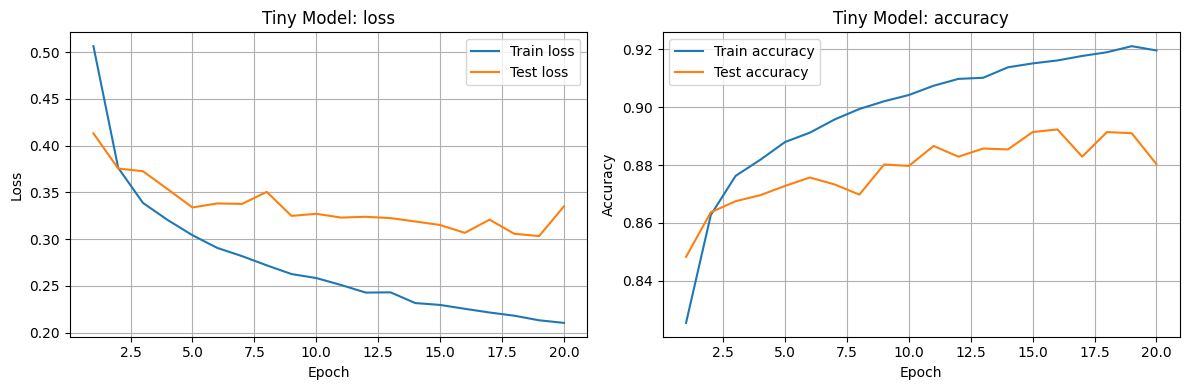

In [99]:
plot_loss_and_accuracy(history_tiny, title_prefix="Tiny Model")

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [113]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 4096),
            nn.ReLU(),

            nn.Linear(4096, 2048),
            nn.ReLU(),

            nn.Linear(2048, 512),
            nn.ReLU(),

            nn.Linear(512, num_classes)
        )

        
    def forward(self, inp):       
        return self.model(inp)

In [114]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 4096]       3,215,360
              ReLU-3                 [-1, 4096]               0
            Linear-4                 [-1, 2048]       8,390,656
              ReLU-5                 [-1, 2048]               0
            Linear-6                  [-1, 512]       1,049,088
              ReLU-7                  [-1, 512]               0
            Linear-8                   [-1, 10]           5,130
Total params: 12,660,234
Trainable params: 12,660,234
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.11
Params size (MB): 48.29
Estimated Total Size (MB): 48.41
----------------------------------------------------------------


In [115]:
model_overfitted = OverfittingNeuralNetwork().to(device)
opt_overfitted = torch.optim.Adam(
    model_overfitted.parameters(),
    lr=1e-3
)
loss_func_overfitted = nn.CrossEntropyLoss()

# Your experiments, come here

In [116]:
from torch.utils.data import Subset

small_train_size = 1500

g = torch.Generator().manual_seed(42)
indices = torch.randperm(len(fmnist_dataset_train), generator=g)[:small_train_size]

fmnist_dataset_train_small = Subset(fmnist_dataset_train, indices)

train_loader_overfitted = torch.utils.data.DataLoader(fmnist_dataset_train_small,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)

In [117]:
num_epochs_overfitted = 40
history_overfitted = train_model(
    model_overfitted,
    train_loader_overfitted,
    test_loader,
    opt_overfitted,
    loss_func_overfitted,
    device,
    num_epochs_overfitted
)

Epoch 01: train_loss=1.4677, train_acc=0.4240, test_loss=0.9633, test_acc=0.6067
Epoch 02: train_loss=0.8524, train_acc=0.6453, test_loss=0.7862, test_acc=0.6708
Epoch 03: train_loss=0.6935, train_acc=0.7200, test_loss=0.7064, test_acc=0.7166
Epoch 04: train_loss=0.5646, train_acc=0.7787, test_loss=0.6382, test_acc=0.7649
Epoch 05: train_loss=0.4728, train_acc=0.8160, test_loss=0.6546, test_acc=0.7711
Epoch 06: train_loss=0.4109, train_acc=0.8433, test_loss=0.6400, test_acc=0.7878
Epoch 07: train_loss=0.4035, train_acc=0.8500, test_loss=0.6757, test_acc=0.7714
Epoch 08: train_loss=0.3984, train_acc=0.8487, test_loss=0.6263, test_acc=0.7924
Epoch 09: train_loss=0.3199, train_acc=0.8840, test_loss=0.6439, test_acc=0.8038
Epoch 10: train_loss=0.3105, train_acc=0.8800, test_loss=0.6331, test_acc=0.7976
Epoch 11: train_loss=0.2675, train_acc=0.8987, test_loss=0.7177, test_acc=0.7870
Epoch 12: train_loss=0.2295, train_acc=0.9167, test_loss=0.6959, test_acc=0.8122
Epoch 13: train_loss=0.2370,

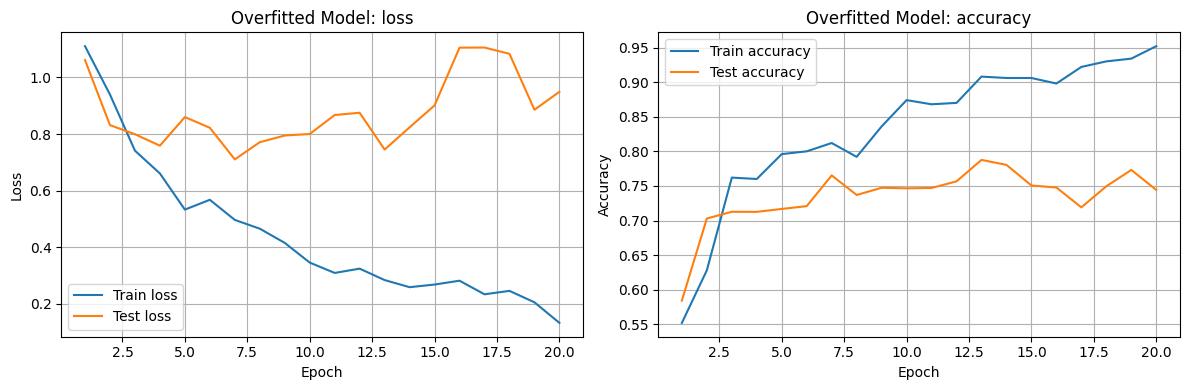

In [107]:
plot_loss_and_accuracy(history_overfitted, title_prefix="Overfitted Model")

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [118]:
dropout_prob = 0.5
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Linear(256, num_classes)
        )

    def forward(self, inp):       
        out = self.model(inp)
        return out

In [119]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
       BatchNorm1d-3                  [-1, 512]           1,024
              ReLU-4                  [-1, 512]               0
           Dropout-5                  [-1, 512]               0
            Linear-6                  [-1, 256]         131,328
       BatchNorm1d-7                  [-1, 256]             512
              ReLU-8                  [-1, 256]               0
           Dropout-9                  [-1, 256]               0
           Linear-10                   [-1, 10]           2,570
Total params: 537,354
Trainable params: 537,354
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 2.05
Estimated T

In [120]:
model_fixed = FixedNeuralNetwork().to(device)
opt_fixed = torch.optim.Adam(
    model_fixed.parameters(),
    lr=1e-3,
    weight_decay=1e-4
)
loss_func_fixed = nn.CrossEntropyLoss()

# Your experiments, come here

In [123]:
num_epochs_fixed = 20
history_fixed = train_model(
    model_fixed,
    train_loader,
    test_loader,
    opt_fixed,
    loss_func_fixed,
    device,
    num_epochs_fixed
)

Epoch 01: train_loss=0.4768, train_acc=0.8294, test_loss=0.4053, test_acc=0.8485
Epoch 02: train_loss=0.4091, train_acc=0.8520, test_loss=0.3711, test_acc=0.8660
Epoch 03: train_loss=0.3830, train_acc=0.8605, test_loss=0.3641, test_acc=0.8678
Epoch 04: train_loss=0.3658, train_acc=0.8669, test_loss=0.3450, test_acc=0.8760
Epoch 05: train_loss=0.3513, train_acc=0.8724, test_loss=0.3457, test_acc=0.8741
Epoch 06: train_loss=0.3400, train_acc=0.8753, test_loss=0.3377, test_acc=0.8763
Epoch 07: train_loss=0.3347, train_acc=0.8777, test_loss=0.3270, test_acc=0.8801
Epoch 08: train_loss=0.3273, train_acc=0.8792, test_loss=0.3261, test_acc=0.8807
Epoch 09: train_loss=0.3204, train_acc=0.8830, test_loss=0.3304, test_acc=0.8751
Epoch 10: train_loss=0.3120, train_acc=0.8848, test_loss=0.3169, test_acc=0.8843
Epoch 11: train_loss=0.3100, train_acc=0.8850, test_loss=0.3281, test_acc=0.8809
Epoch 12: train_loss=0.3073, train_acc=0.8873, test_loss=0.3185, test_acc=0.8824
Epoch 13: train_loss=0.3009,

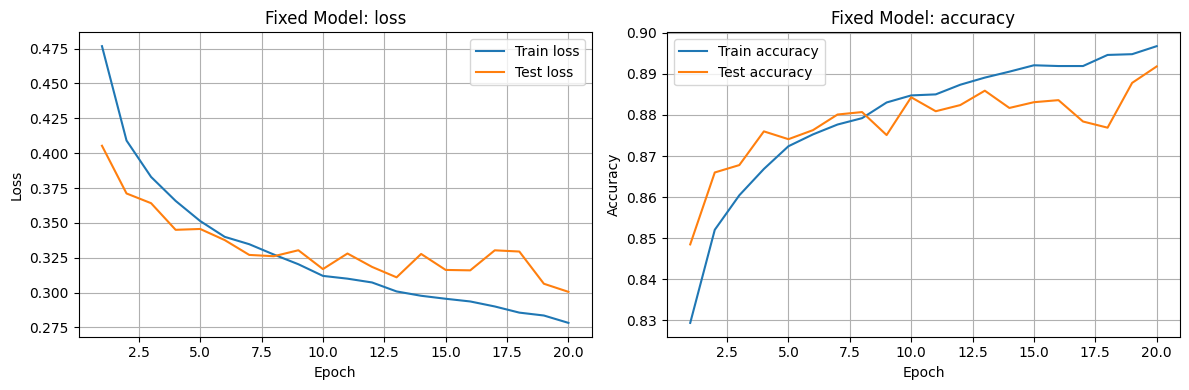

In [124]:
plot_loss_and_accuracy(history_fixed, title_prefix="Fixed Model")

### Conclusions:
_Write down small report with your conclusions and your ideas._

проблему переобучения удалось решить за счет использования нескольких инструментов:
  - увеличить объем данных для обучения
  - упросить модель, избавиться от лишних слоев
  - регуляризация для оптимизатора
  - dropout (выелючает нейроны) и batchnormalization (стабилизирует обучение)